In [1]:
# Import libraries
import glob
import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import sys
import matplotlib
import scienceplots
import matplotlib.colors as mcolors
from matplotlib.offsetbox import AnchoredText
plt.style.use('science')

%matplotlib inline

import libgeohash as gh
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point

import contextily as cx
import xyzservices.providers as xyz

/Users/mnunez/opt/anaconda3/envs/graphwork/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
def getPolygon (geoHash):
    auxGeoHash = gh.bbox(geoHash)
    p = Polygon([
    Point([auxGeoHash['w'],auxGeoHash['n']]),
    Point([auxGeoHash['e'],auxGeoHash['n']]),
    Point([auxGeoHash['e'],auxGeoHash['s']]),
    Point([auxGeoHash['w'],auxGeoHash['s']])
    ])
    return p


In [3]:
#geohash_5,no_of_points,no_of_unique_users,local_time,local_date
#20191231 21:00:00 - 24:00:00,20191231

def generateDate (day, month, year):
    
    strDate = str(year)
    if int(month) < 10:
        strDate += "0"+str(month)
    else:
        strDate += str(month)
    if int(day) < 10:
        strDate += "0"+str(day)
    else:
        strDate += str(day)
        
    return strDate 

def generateRank (interval,local_time):

    dict_local_time = {0:'00:00:00 - 03:00:00',
                      1:'03:00:00 - 06:00:00',
                      2:'06:00:00 - 09:00:00',
                      3:'09:00:00 - 12:00:00',
                      4:'12:00:00 - 15:00:00',
                      5:'15:00:00 - 18:00:00',
                      6:'18:00:00 - 21:00:00',
                      7:'21:00:00 - 00:00:00'}
    
    return local_time + " " + dict_local_time[int(interval)] 

# AGG 5

In [ ]:
country_code = 'MX'
country_name = 'Mexico'
year = '2020'
agg_level = '5'

In [ ]:
# Get CSV files list from a folder
path = "../data/popDensity/{}/{}".format(country_code,year)
csv_files = glob.glob(path + "/{}_daily_agg5_hour_*.csv_kanonnimized.csv".format(country_code))
i = 1
for file in csv_files:
    print(i, file)
    i+=1 
# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
big_df   = pd.concat(df_list, ignore_index=True)

big_df['local_date'] = big_df.apply(lambda x: generateDate(x['day'],x['month'],year),axis = 1)
big_df['local_time'] = big_df.apply(lambda x: generateRank(x['grt'],x['local_date']),axis = 1)
big_df = big_df.drop(columns=['grt', 'day', 'month'])
big_df = big_df[['geohash5','no_of_points','no_of_unique_users', 'local_time', 'local_date']]
big_df.columns = ['geohash_5','no_of_points','no_of_unique_users', 'local_time', 'local_date']
big_df.sort_values(by=['local_time'], ascending=True, inplace= True)
big_df.head()

In [ ]:
big_df.to_csv(path+"/pd_{}_{}_3h_agg{}.csv".format(str.lower(country_code),year,agg_level,year), index=False )
print ("Saved on: " + path+"/pd_{}_{}_3h_agg{}.csv".format(str.lower(country_code),agg_level,year))

## Plot

In [ ]:
grouped = big_df[["geohash_5","no_of_unique_users","no_of_points"]].groupby('geohash_5')
average_popDensity = grouped.mean().reset_index()
average_popDensity['no_of_unique_users'] = average_popDensity['no_of_unique_users'].astype(int)
average_popDensity['no_of_points'] = average_popDensity['no_of_points'].astype(int)

average_popDensity.to_csv(path+"/{}_popDensity_agg{}_{}_avg.csv".format(country_code,agg_level,year), index=False )
print ("Saved on: " + path+"/{}_popDensity_agg{}_{}_avg.csv".format(country_code,agg_level,year))


In [ ]:
average_popDensity['geometry'] = average_popDensity['geohash_5'].apply(getPolygon)
average_popDensity_gdf = gpd.GeoDataFrame(
    average_popDensity, geometry=average_popDensity.geometry, crs="EPSG:4326"
)
average_popDensity_gdf.head()

In [ ]:
fig, ax = plt.subplots( )
n_bins = 50
ax.hist(average_popDensity_gdf[['no_of_unique_users']].values, bins=n_bins, color=mcolors.CSS4_COLORS['lightsteelblue'])
ax.set_xlabel('Average number of unique devices ({} {}, Geohash {})'.format(country_name,year,agg_level)) 

ax.set_ylabel('Frequency') 
plt.savefig("../outputs/{}_avg_devices_3h_agg{}_{}.png".format(country_code,agg_level,year))

In [ ]:
fig, ax = plt.subplots( )
n_bins = 50
ax.hist(average_popDensity_gdf[['no_of_points']].values, bins=n_bins, color=mcolors.CSS4_COLORS['lightsteelblue'])
ax.set_xlabel('Average number of points ({} {}, Geohash {})'.format(country_name,year,agg_level)) 
ax.set_ylabel('Frequency') 
plt.savefig("../outputs/{}_avg_points_3h_agg{}_{}.png".format(country_code,agg_level,year))

## Timeseries

In [ ]:
grouped_time = big_df[["local_time","no_of_unique_users","no_of_points"]].groupby('local_time')
average_popDensity = grouped_time.sum().reset_index()
average_popDensity['no_of_unique_users'] = average_popDensity['no_of_unique_users'].astype(int)
average_popDensity['no_of_points'] = average_popDensity['no_of_points'].astype(int)
average_popDensity['time'] = pd.to_datetime(average_popDensity['local_time'].str.slice(0,18))
average_popDensity = average_popDensity.drop('local_time', axis=1)
average_popDensity = average_popDensity.set_index('time')
average_popDensity.head()

In [ ]:
fig, ax = plt.subplots( )
ax.plot(average_popDensity.index,average_popDensity[['no_of_unique_users']].values,  color=mcolors.CSS4_COLORS['lightsteelblue'])

ax.set_ylabel('Number of unique devices'.format(country_name,year,agg_level)) 

ax.set_xlabel('Time') 
plt.savefig("../outputs/{}_devices_over_time_3h_agg{}_{}.png".format(country_code,agg_level,year))

In [ ]:
fig, ax = plt.subplots( )
ax.plot(average_popDensity.index,average_popDensity[['no_of_points']].values,  color=mcolors.CSS4_COLORS['lightsteelblue'])

ax.set_ylabel('Number of points'.format(country_name,year,agg_level)) 

ax.set_xlabel('Time') 
plt.savefig("../outputs/{}_points_over_time_3h_agg{}_{}.png".format(country_code,agg_level,year))

In [ ]:
## Maps

In [ ]:
ax = average_popDensity_gdf.plot(color="red",edgecolor="black",markersize=50,figsize=(15, 15))
cx.add_basemap(ax, crs=average_popDensity_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 


average_popDensity_gdf.plot(
    ax=ax,
    cmap='viridis_r',
    column="no_of_unique_users",
    legend=True,
    legend_kwds={"label": "Number of average unique devices", "orientation": "horizontal"},
    
)
#plt.subplots_adjust(bottom=0.5)
text = AnchoredText('Average number of unique devices in {} {} for 3 hours interval using Geohash {}'.format(country_name,year,agg_level),loc=1, prop={'size': 10}, frameon=True)
ax.add_artist(text)



plt.savefig("../outputs/map_{}_avg_devices_3h_agg{}_{}.png".format(country_code,year,agg_level),bbox_inches='tight',dpi=300)

In [ ]:
ax = average_popDensity_gdf.plot(color="red",edgecolor="black",markersize=50,figsize=(15, 15))
cx.add_basemap(ax, crs=average_popDensity_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 


average_popDensity_gdf.plot(
    ax=ax,
    cmap='viridis_r',
    column="no_of_points",
    legend=True,
    legend_kwds={"label": "Average number of points", "orientation": "horizontal"},
    
)
#plt.subplots_adjust(bottom=0.5)
text = AnchoredText('Average number of points in {} {} for 3 hours interval using Geohash {}'.format(country_name,year,agg_level),loc=1, prop={'size': 10}, frameon=True)
ax.add_artist(text)

plt.savefig("../outputs/map_{}_avg_points_3h_agg{}_{}.png".format(country_code,year,agg_level),bbox_inches='tight',dpi=300)


## AGG 3

In [4]:
country_code = 'MX'
country_name = 'Mexico'
year = '2020'
agg_level = '3'
threshold = 10

In [5]:
# Get CSV files list from a folder
path = "../data/popDensity/{}/{}/original".format(country_code,year)
csv_files = glob.glob(path + "/{}_daily_agg5_hour_*.csv".format(country_code))
i = 1
for file in csv_files:
    print(i, file)
    i+=1 
      
# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
big_df_agg3   = pd.concat(df_list, ignore_index=True)

big_df_agg3['local_date'] = big_df_agg3.apply(lambda x: generateDate(x['day'],x['month'],year),axis = 1)
big_df_agg3['local_time'] = big_df_agg3.apply(lambda x: generateRank(x['grt'],x['local_date']),axis = 1)
big_df_agg3 = big_df_agg3.drop(columns=['grt', 'day', 'month'])
big_df_agg3 = big_df_agg3[['geohash5','no_of_points','no_of_unique_users', 'local_time', 'local_date']]
big_df_agg3.columns = ['geohash_5','no_of_points','no_of_unique_users', 'local_time', 'local_date']
big_df_agg3.sort_values(by=['local_time'], ascending=True, inplace= True)

1 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_feb.csv
2 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_dec.csv
3 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_mar.csv
4 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_apr.csv
5 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_jan.csv
6 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_nov.csv
7 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_jun.csv
8 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_jul.csv
9 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_oct.csv
10 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_may.csv
11 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_aug.csv
12 ../data/popDensity/MX/2020/original/MX_daily_agg5_hour_set.csv


In [6]:
#geohash_5	no_of_points	no_of_unique_users	local_time	local_date
big_df_agg3['geohash_3'] = big_df_agg3['geohash_5'].str.slice(0,3)
big_df_agg3 = big_df_agg3.drop('geohash_5', axis=1)
grp_big_df_agg3 = big_df_agg3.groupby(['local_time','local_date','geohash_3']).sum()
grp_big_df_agg3.reset_index(inplace=True)
print ("Before k-anonimity {}".format(grp_big_df_agg3.shape[0]))
grp_big_df_agg3 = grp_big_df_agg3[ grp_big_df_agg3['no_of_unique_users'] >= threshold ]
print ("After k-anonimity {}".format(grp_big_df_agg3.shape[0]))
big_df_agg3.head()

Before k-anonimity 381553
After k-anonimity 333614


,no_of_points,no_of_unique_users,local_time,local_date,geohash_3
10390277,66,18,20200101 00:00:00 - 03:00:00,20200101,9g3
10401668,9,2,20200101 00:00:00 - 03:00:00,20200101,9et
10401669,9,4,20200101 00:00:00 - 03:00:00,20200101,9gc
10401674,1,1,20200101 00:00:00 - 03:00:00,20200101,9fw
10401675,1,1,20200101 00:00:00 - 03:00:00,20200101,9ey


In [7]:
grp_big_df_agg3.to_csv(path+"/pd_{}_{}_3h_agg{}.csv".format(str.lower(country_code),year,agg_level,year), index=False )
print ("Saved on: " + path+"/pd_{}_{}_3h_agg{}.csv".format(str.lower(country_code),agg_level,year))

Saved on: ../data/popDensity/MX/2020/original/pd_mx_3_3h_agg2020.csv


## Plot

In [8]:
grouped = grp_big_df_agg3[["geohash_3","no_of_unique_users","no_of_points"]].groupby('geohash_3')
average_popDensity = grouped.mean().reset_index()
average_popDensity['no_of_unique_users'] = average_popDensity['no_of_unique_users'].astype(int)

average_popDensity.to_csv(path+"/{}_popDensity_agg{}_{}_avg.csv".format(country_code,agg_level,year), index=False )
print ("Saved on: " + path+"/{}_popDensity_agg{}_{}_avg.csv".format(country_code,agg_level,year))


Saved on: ../data/popDensity/MX/2020/original/MX_popDensity_agg3_2020_avg.csv


In [9]:
average_popDensity['geometry'] = average_popDensity['geohash_3'].apply(getPolygon)
average_popDensity_gdf = gpd.GeoDataFrame(
    average_popDensity, geometry=average_popDensity.geometry, crs="EPSG:4326"
)
average_popDensity_gdf.head()

,geohash_3,no_of_unique_users,no_of_points,geometry
0,9e3,12,66.000000,"POLYGON ((-111.09375 19.68750, -109.68750 19.6..."
1,9em,270,1574.392418,"POLYGON ((-105.46875 19.68750, -104.06250 19.6..."
2,9en,14,107.977778,"POLYGON ((-104.06250 18.28125, -102.65625 18.2..."
3,9ep,256,2056.492486,"POLYGON ((-102.65625 18.28125, -101.25000 18.2..."
4,9eq,760,3743.171790,"POLYGON ((-104.06250 19.68750, -102.65625 19.6..."


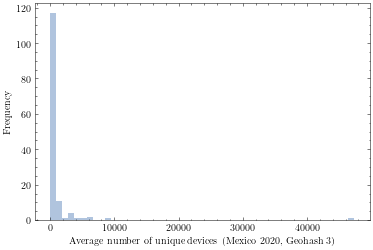

In [10]:
fig, ax = plt.subplots( )
n_bins = 50
ax.hist(average_popDensity_gdf[['no_of_unique_users']].values, bins=n_bins, color=mcolors.CSS4_COLORS['lightsteelblue'])
ax.set_xlabel('Average number of unique devices ({} {}, Geohash {})'.format(country_name,year,agg_level)) 
ax.set_ylabel('Frequency') 
plt.savefig("../outputs/{}_avg_devices_3h_agg{}_{}.png".format(country_code,agg_level,year))

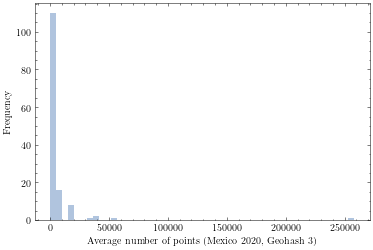

In [11]:
fig, ax = plt.subplots( )
n_bins = 50
ax.hist(average_popDensity_gdf[['no_of_points']].values, bins=n_bins, color=mcolors.CSS4_COLORS['lightsteelblue'])
ax.set_xlabel('Average number of points ({} {}, Geohash {})'.format(country_name,year,agg_level)) 
ax.set_ylabel('Frequency') 
plt.savefig("../outputs/{}_avg_points_3h_agg{}_{}.png".format(country_code,agg_level,year))

## Timeseries

In [12]:
grp_big_df_agg3 = big_df[["local_time","no_of_unique_users","no_of_points"]].groupby('local_time')
average_popDensity = grp_big_df_agg3.sum().reset_index()
average_popDensity['no_of_unique_users'] = average_popDensity['no_of_unique_users'].astype(int)
average_popDensity['no_of_points'] = average_popDensity['no_of_points'].astype(int)
average_popDensity['time'] = pd.to_datetime(average_popDensity['local_time'].str.slice(0,18))
average_popDensity = average_popDensity.drop('local_time', axis=1)
average_popDensity = average_popDensity.set_index('time')
average_popDensity.head()

NameError: name 'big_df' is not defined

In [ ]:
fig, ax = plt.subplots( )
ax.plot(average_popDensity.index,average_popDensity[['no_of_unique_users']].values,  color=mcolors.CSS4_COLORS['lightsteelblue'])

ax.set_ylabel('Number of unique devices'.format(country_name,year,agg_level)) 

ax.set_xlabel('Time') 
plt.savefig("../outputs/{}_devices_over_time_3h_agg{}_{}.png".format(country_code,agg_level,year))

In [ ]:
fig, ax = plt.subplots( )
ax.plot(average_popDensity.index,average_popDensity[['no_of_points']].values,  color=mcolors.CSS4_COLORS['lightsteelblue'])

ax.set_ylabel('Number of points'.format(country_name,year,agg_level)) 

ax.set_xlabel('Time') 
plt.savefig("../outputs/{}_points_over_time_3h_agg{}_{}.png".format(country_code,agg_level,year))

## Maps

In [ ]:
ax = average_popDensity_gdf.plot(color="red",edgecolor="black",markersize=50,figsize=(15, 15))
cx.add_basemap(ax, crs=average_popDensity_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 


average_popDensity_gdf.plot(
    ax=ax,
    cmap='viridis_r',
    column="no_of_unique_users",
    legend=True,
    legend_kwds={"label": "Number of average unique devices", "orientation": "horizontal"},
    
)
#plt.subplots_adjust(bottom=0.5)
text = AnchoredText('Average number of unique devices in {} {} for 3 hours interval using Geohash {}'.format(country_name,year,agg_level),loc=1, prop={'size': 10}, frameon=True)
ax.add_artist(text)



plt.savefig("../outputs/map_{}_avg_devices_3h_agg{}_{}.png".format(country_code,year,agg_level),bbox_inches='tight',dpi=300)

In [ ]:
ax = average_popDensity_gdf.plot(color="red",edgecolor="black",markersize=50,figsize=(15, 15))
cx.add_basemap(ax, crs=average_popDensity_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 


average_popDensity_gdf.plot(
    ax=ax,
    cmap='viridis_r',
    column="no_of_points",
    legend=True,
    legend_kwds={"label": "Average number of points", "orientation": "horizontal"},
    
)
#plt.subplots_adjust(bottom=0.5)
text = AnchoredText('Average number of points in {} {} for 3 hours interval using Geohash {}'.format(country_name,year,agg_level),loc=1, prop={'size': 10}, frameon=True)
ax.add_artist(text)

plt.savefig("../outputs/map_{}_avg_points_3h_agg{}_{}.png".format(country_code,year,agg_level),bbox_inches='tight',dpi=300)
